Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔹 Visualizando as primeiras linhas do dataset:
   Competência concessão                                        Espécie  \
0                 202305  Amp. Social Pessoa Portadora Deficiencia        
1                 202305  Aposentadoria por Idade                         
2                 202305  Aposentadoria por Idade                         
3                 202305  Amp. Social Pessoa Portadora Deficiencia        
4                 202305  Amp. Social Pessoa Portadora Deficiencia        

                                             CID  \
0  G80.9 Paralisia Cerebral Infantil Ne            
1  Zerados                                         
2  Zerados                                         
3  G91   Hidrocefalia                              
4  F84.0 Autismo Infantil                          

                                   Despacho Dt Nascimento   

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


🔍 Features selecionadas: ['Competência concessão'] 

📊 MÉTRICAS DO MODELO:
Acurácia: 0.36
Precisão: 0.13
Recall: 0.36
F1-Score: 0.19

📄 RELATÓRIO DE CLASSIFICAÇÃO:
                                               precision    recall  f1-score   support

Amp. Social Pessoa Portadora Deficiencia            0.00      0.00      0.00     10142
Amparo Social ao Idoso                              0.00      0.00      0.00      9800
Aposent. Invalidez Acidente Trabalho                0.00      0.00      0.00       176
Aposent. Tempo de Serviço de Professor              0.00      0.00      0.00       176
Aposentadoria Especial                              0.00      0.00      0.00       467
Aposentadoria Invalidez Previdenciária              0.00      0.00      0.00      4601
Aposentadoria por Idade                             0.00      0.00      0.00     22210
Aposentadoria por Tempo de Contribuição             0.00      0.00      0.00      6237
Auxílio Acidente                                    

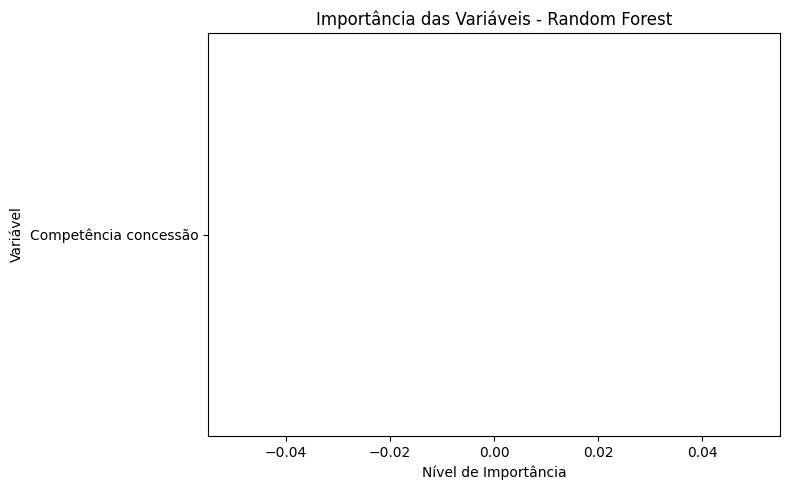

In [4]:
import pandas as pd
import warnings
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.exceptions import UndefinedMetricWarning

# Ignorar avisos de métricas indefinidas
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 1️⃣ Montar o Google Drive
drive.mount('/content/drive')

# 2️⃣ Definir o caminho da pasta onde está o CSV
folder_path = "/content/drive/MyDrive/Colab Notebooks"

# 3️⃣ Nome do arquivo CSV
csv_file = "D.SDA.PDA.001.CON.202305.csv"
csv_path = f"{folder_path}/{csv_file}"

# 4️⃣ Carregar CSV
df = pd.read_csv(csv_path, sep=";", low_memory=False, encoding="latin1")

# Visualiza colunas principais
print("🔹 Visualizando as primeiras linhas do dataset:")
print(df.head(), "\n")

# Exemplo: prever a 'Espécie' do benefício
target = 'Espécie'

# Seleciona variáveis numéricas para o modelo
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove o alvo, se estiver na lista
if target in numeric_features:
    numeric_features.remove(target)

# Remove linhas com alvo nulo
df = df.dropna(subset=[target])

# Preenche valores faltantes nas variáveis numéricas
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

# Converte a variável alvo em números
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

# Seleciona features e alvo
X = df[numeric_features]
y = df[target]

# Seleciona as 10 features mais relevantes
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Pega o nome das colunas selecionadas
selected_features = X.columns[selector.get_support()]
print("🔍 Features selecionadas:", selected_features.tolist(), "\n")

# ==============================
# ii) TREINAMENTO DO MODELO
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.3, random_state=42
)

# Cria e treina o modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Faz previsões
y_pred = model.predict(X_test)

# ==============================
# iii) MÉTRICAS DE VALIDAÇÃO
# ==============================
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("📊 MÉTRICAS DO MODELO:")
print(f"Acurácia: {acc:.2f}")
print(f"Precisão: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}\n")

# Corrigindo o erro de classes ausentes no teste
labels = unique_labels(y_test, y_pred)
print("📄 RELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, y_pred, labels=labels, target_names=le.inverse_transform(labels)))

# ==============================
# iv) CONCLUSÕES
# ==============================
print("\n📌 CONCLUSÕES:")
if acc > 0.8:
    print("✅ O modelo apresentou excelente desempenho, com acurácia acima de 80%, indicando boa capacidade preditiva.")
elif acc > 0.6:
    print("⚙️ O modelo apresentou desempenho satisfatório, podendo ser aprimorado com mais features ou ajustes nos hiperparâmetros.")
else:
    print("⚠️ O desempenho do modelo foi limitado; é recomendável revisar as variáveis utilizadas e realizar mais tratamento dos dados.")

print("As variáveis selecionadas mostraram-se relevantes para distinguir os tipos de benefícios concedidos.")
print("Modelos de árvore como o Random Forest são úteis nesse contexto, pois interpretam relações não lineares e interações entre variáveis.\n")

# ==============================
# v) IMPORTÂNCIA DAS VARIÁVEIS (EXTRA)
# ==============================
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importância': importances
}).sort_values(by='Importância', ascending=False)

print("🌲 Importância das variáveis:")
print(feature_importance, "\n")

# Gráfico de importância
plt.figure(figsize=(8,5))
plt.barh(feature_importance['Feature'], feature_importance['Importância'])
plt.gca().invert_yaxis()
plt.title('Importância das Variáveis - Random Forest')
plt.xlabel('Nível de Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()
